In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pygmt
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split


In [2]:
p_feats = pd.concat([pd.read_csv('data/features/p_features.csv'), pd.read_csv('data/features/p_features.2022.csv')])
s_feats = pd.concat([pd.read_csv('data/features/s_features.csv'),  pd.read_csv('data/features/s_features.2022.csv')])

In [3]:
ev_cat = pd.read_csv('data/catalogs/yellowstone.events.ypml-v5.2023.csv')
arr_cat = pd.read_csv('data/catalogs/yellowstone.arrivals.2023.csv')
arr_cat = arr_cat[arr_cat['evid'].isin(ev_cat['Evid'].unique())]

In [4]:
def describe_feats(phase_df, phase, ev_df):
    print(f"There are {len(phase_df.drop_duplicates('event_identifier'))} events and \
{len(phase_df)} arrivals in the {phase.upper()} feature catalog between \
{ev_df[ev_df['Evid'].isin(phase_df['event_identifier'].unique())]['Date'].min()} and \
{ev_df[ev_df['Evid'].isin(phase_df['event_identifier'].unique())]['Date'].max()}")
    
describe_feats(p_feats, "P", ev_cat)
describe_feats(s_feats, "S", ev_cat)

There are 6612 events and 75492 arrivals in the P feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2022-07-27 03:20:04.930000+00:00
There are 5799 events and 14619 arrivals in the S feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2022-07-27 03:20:04.930000+00:00


# Choose temporal split

In [5]:
train_frac = 0.8

In [37]:
ev_cat['Date'] = pd.to_datetime(ev_cat['Date'], format='mixed')
p_ev = ev_cat[ev_cat['Evid'].isin(p_feats['event_identifier'].unique())].sort_values('Date')
s_ev = ev_cat[ev_cat['Evid'].isin(s_feats['event_identifier'].unique())].sort_values('Date')
print(f"P event count: {p_ev.shape[0]}; S event count: {s_ev.shape[0]}")

P event count: 6611; S event count: 5798


In [39]:
p_ev.iloc[int(p_ev.shape[0]*train_frac)]["Date"]

Timestamp('2020-05-22 08:24:47.320000+0000', tz='UTC')

In [40]:
s_ev.iloc[int(s_ev.shape[0]*train_frac)]["Date"]

Timestamp('2020-07-11 18:38:51.320000+0000', tz='UTC')

In [223]:
train_cutoff = datetime(2020, 7, 1, tzinfo=timezone.utc) #np.datetime64('2020-07-01')
p_train_evids = p_ev[p_ev['Date'] < train_cutoff]['Evid']
s_train_evids = s_ev[s_ev['Date'] < train_cutoff]['Evid']
p_test_evids = p_ev[p_ev['Date'] >= train_cutoff]['Evid']
s_test_evids = s_ev[s_ev['Date'] >= train_cutoff]['Evid']
p_train_feats = p_feats[p_feats['event_identifier'].isin(p_train_evids)]
s_train_feats = s_feats[s_feats['event_identifier'].isin(s_train_evids)]
p_test_feats = p_feats[p_feats['event_identifier'].isin(p_test_evids)]
s_test_feats = s_feats[s_feats['event_identifier'].isin(s_test_evids)]

In [224]:
print(f"P training size: {(p_train_evids.shape[0]/p_ev.shape[0])*100:0.2f} % \n\
S training size: {(s_train_evids.shape[0]/s_ev.shape[0])*100:0.2f} %")

P training size: 81.47 % 
S training size: 79.84 %


# If decide to do an evid split instead, run these. 

In [262]:
# Evid split
evid_split_max_time = datetime(2022, 1, 1, tzinfo=timezone.utc)
#train_evids, test_evids = train_test_split(ev_cat[ev_cat['Date'] < evid_split_max_time]['Evid'].values, test_size=1-train_frac, train_size=train_frac)
train_evids, test_evids = train_test_split(np.unique(np.concatenate([p_ev['Evid'], s_ev['Evid']])), test_size=1-train_frac, train_size=train_frac)

In [263]:
train_cutoff = datetime(2020, 7, 1, tzinfo=timezone.utc) #np.datetime64('2020-07-01')
print(f"P training size: {(p_ev[p_ev['Evid'].isin(train_evids)].shape[0]/p_ev.shape[0])*100:0.2f} % \n\
S training size: {(s_ev[s_ev['Evid'].isin(train_evids)].shape[0]/s_ev.shape[0])*100:0.2f} %")

P training size: 79.99 % 
S training size: 79.65 %


In [264]:
p_train_feats = p_feats[p_feats['event_identifier'].isin(train_evids)]
s_train_feats = s_feats[s_feats['event_identifier'].isin(train_evids)]
p_test_feats = p_feats[p_feats['event_identifier'].isin(test_evids)]
s_test_feats = s_feats[s_feats['event_identifier'].isin(test_evids)]

# Look into the number of stations

In [56]:
def plot_box_whisker(df, feature, ylabel=None, sort_counts=True, thresholds=None, showfliers=True, min_y_line=None):
    fig = plt.figure(figsize=(15, 5))
    station_feat = df.groupby("station").apply(lambda x: x[feature].values).to_frame()
    station_feat.columns = ["values"]
    if sort_counts:
        station_feat.loc[:, "counts"] = station_feat.apply(lambda x: len(x["values"]), axis=1)
        station_feat = station_feat.sort_values("counts", ascending=False)
        
    if thresholds is not None:
        for thresh in thresholds: 
            thresh_ind = np.where(station_feat.counts < thresh)[0][0] + 0.5
            plt.axvline(thresh_ind, color="red", alpha=0.5)

    if min_y_line is not None:
        plt.axhline(min_y_line, color='r')
    labels = station_feat.index
    plt.boxplot(station_feat["values"].to_numpy(), showfliers=showfliers);
    plt.xticks(range(1, len(labels)+1), labels=labels, rotation="vertical");
    if ylabel is None:
        ylabel = feature
    plt.ylabel(ylabel)

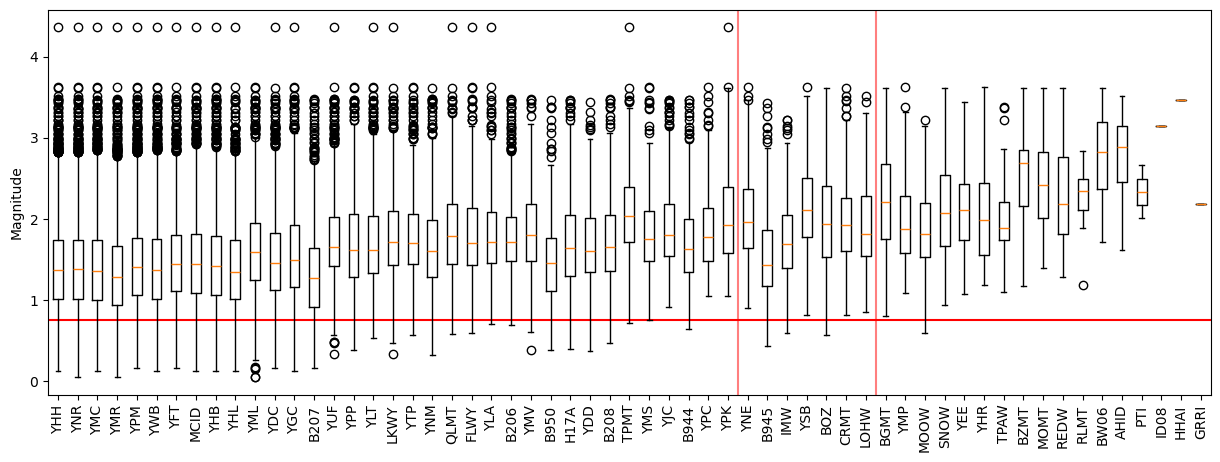

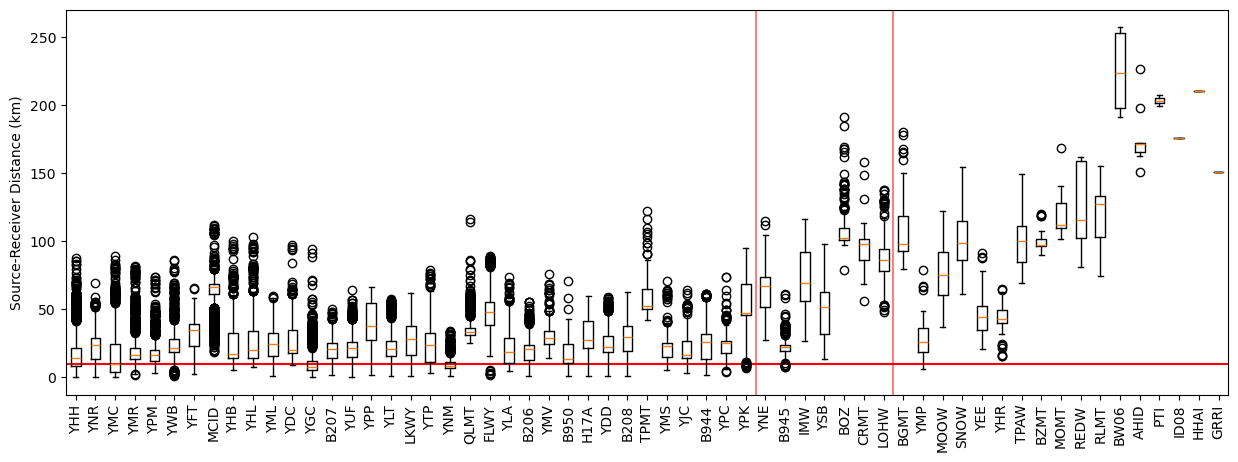

In [252]:
plot_box_whisker(p_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=0.75)
plot_box_whisker(p_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

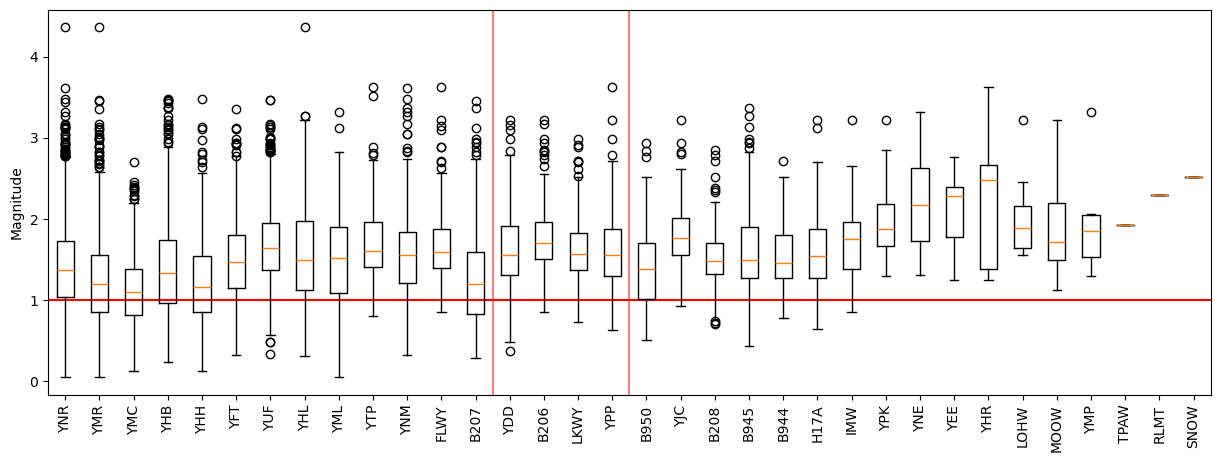

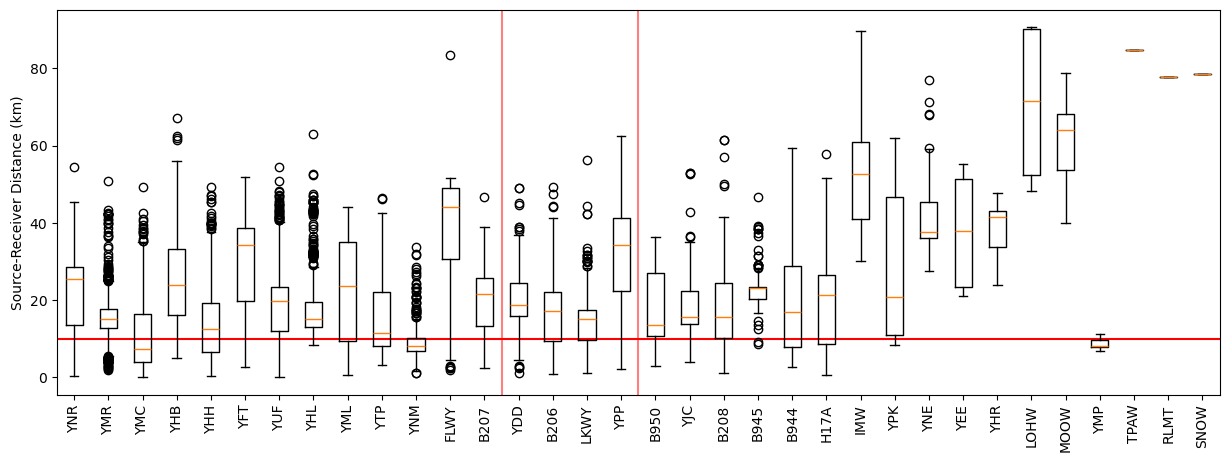

In [251]:
plot_box_whisker(s_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=1.0)
plot_box_whisker(s_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

In [265]:
p_counts = p_train_feats.groupby('station')['station'].count().rename('cnt').reset_index().merge(p_test_feats.groupby('station')['station'].count().rename('cnt').reset_index(),
                                                                                      how='outer', on='station').sort_values('cnt_x', ascending=False)

In [266]:
s_counts = s_train_feats.groupby('station')['station'].count().rename('cnt').reset_index().merge(s_test_feats.groupby('station')['station'].count().rename('cnt').reset_index(),
                                                                                      how='outer', on='station').sort_values('cnt_x', ascending=False)

In [267]:
p_min_train = 150
p_min_test = round(p_min_train*.25)
s_min_train = 300
s_min_test = round(s_min_train*.25)
print("P", p_min_train, p_min_test, p_min_test+p_min_train)
print("S", s_min_train, s_min_test, s_min_test+s_min_train)

P 150 38 188
S 300 75 375


In [268]:
p_good_stats = p_counts[(p_counts['cnt_x'] > p_min_train) & (p_counts['cnt_y'] > p_min_test)]
p_good_stats.shape[0]

42

In [269]:
p_almost_stats = p_counts[(np.nansum([p_counts['cnt_x'], p_counts['cnt_y']], axis=0) > (p_min_test+p_min_train)) &
                           ((p_counts['cnt_y'] < p_min_test) | np.isnan(p_counts['cnt_y']) | (p_counts['cnt_x'] < p_min_train))]
p_almost_stats

,station,cnt_x,cnt_y
7,BGMT,158,36.0


In [272]:
s_good_stats = s_counts[(s_counts['cnt_x'] > s_min_train) & (s_counts['cnt_y'] > s_min_test)]
s_good_stats.shape

(12, 3)

In [271]:
s_almost_stats = s_counts[(np.nansum([s_counts['cnt_x'], s_counts['cnt_y']], axis=0) > (s_min_test+s_min_train)) & 
                          ((s_counts['cnt_y'] < s_min_test) | np.isnan(s_counts['cnt_y']) | (s_counts['cnt_x'] < s_min_train))]
s_almost_stats

,station,cnt_x,cnt_y
6,FLWY,326.0,72.0


In [243]:
s_counts[(np.nansum([s_counts['cnt_x'], s_counts['cnt_y']], axis=0) > (s_min_test+s_min_train))]

,station,cnt_x,cnt_y
29,YNR,1790,459.0
26,YMR,1312,348.0
23,YMC,1236,292.0
18,YHB,1017,244.0
19,YHH,933,235.0
17,YFT,775,194.0
33,YUF,754,192.0
20,YHL,481,109.0
24,YML,428,100.0
32,YTP,386,98.0


In [244]:
p_feats[p_feats.station.isin(p_almost_stats['station'])].groupby('station').apply(lambda x: ev_cat[ev_cat['Evid'].isin(x['event_identifier'])]['Date'].describe().loc[['min', 'max']])

,arrival_identifier,avg_noise_1.00,avg_noise_10.00,avg_noise_11.00,avg_noise_12.00,avg_noise_13.00,avg_noise_14.00,avg_noise_15.00,avg_noise_16.00,avg_noise_17.00,...,signal_dominant_frequency,signal_maximum_value,signal_minimum_value,signal_variance,source_depth_km,source_latitude,source_longitude,source_receiver_back_azimuth,source_receiver_distance_km,station
station,,,,,,,,,,,,,,,,,,,,,


In [245]:
s_feats[s_feats.station.isin(s_almost_stats['station'])].groupby('station').apply(lambda x: ev_cat[ev_cat['Evid'].isin(x['event_identifier'])]['Date'].describe().loc[['min', 'max']])

,arrival_identifier,channel1,channel2,event_identifier,location_code,magnitude,magnitude_type,network,radial_avg_noise_1.00,radial_avg_noise_10.00,...,transverse_noise_dominant_amplitude,transverse_noise_dominant_frequency,transverse_noise_maximum_value,transverse_noise_minimum_value,transverse_noise_variance,transverse_signal_dominant_amplitude,transverse_signal_dominant_frequency,transverse_signal_maximum_value,transverse_signal_minimum_value,transverse_signal_variance
station,,,,,,,,,,,,,,,,,,,,,
